In [12]:
import os
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from astropy.coordinates import SkyCoord
from astropy.io import fits
from gammapy.irf import load_irf_dict_from_file
from scipy.stats import poisson

In [13]:
blazar_coord = SkyCoord.from_name("1ES 0229+200")
data_folder = "../data/1ES_0229+200/"
irf_file = "../data/irfs/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits.gz"

In [14]:
blazar_l = blazar_coord.galactic.l.deg
blazar_b = blazar_coord.galactic.b.deg

hbus = []
for filename in os.listdir(data_folder):
    hbus.append(fits.open(data_folder + filename))

irf = load_irf_dict_from_file(irf_file)
aeff = irf["aeff"]

**Data collecting and overview**

In [26]:
# Source - background cake angle
src_angle = 0.2
# Extended emission angle
ext_angle = 0.25

data = {
    "src_energy": np.array([]),
    "ext_src_energy": np.array([]),
    "src_sep": np.array([]),
    "bkg_energy": np.array([]),
    "ext_bkg_energy": np.array([]),
    "all_coords_l": np.array([]),
    "all_coords_b": np.array([]),
    "all_energies": np.array([]),
    "all_sep": np.array([]),
    "offsets": np.array([]),
    "t_tot": np.array([]),
}

for hbu in hbus:
    data_raw = hbu["EVENTS"].data

    coord = SkyCoord(
        ra=data_raw["RA"] * u.deg, dec=data_raw["DEC"] * u.deg, frame="icrs"
    )

    pointing_coord = SkyCoord(
        ra=hbu[1].header["RA_PNT"] * u.deg,
        dec=hbu[1].header["DEC_PNT"] * u.deg,
        frame="icrs",
    )

    bkg_center = SkyCoord(
        l=2 * pointing_coord.galactic.l - blazar_coord.galactic.l,
        b=2 * pointing_coord.galactic.b - blazar_coord.galactic.b,
        frame="galactic",
    )

    src_pos_mask = coord.separation(blazar_coord).degree < src_angle
    bkg_pos_mask = coord.separation(bkg_center).degree < src_angle
    ext_src_pos_mask = coord.separation(blazar_coord).degree > ext_angle
    ext_bkg_pos_mask = coord.separation(bkg_center).degree > ext_angle

    t = data_raw["TIME"]
    t = np.sort(t)
    t_tot = t[-1] - t[0]

    data["src_energy"] = np.concatenate(
        [data["src_energy"], data_raw["ENERGY_TRUE"][src_pos_mask]]
    )

    data["bkg_energy"] = np.concatenate(
        [data["bkg_energy"], data_raw["ENERGY_TRUE"][bkg_pos_mask]]
    )

    data["ext_src_energy"] = np.concatenate(
        [
            data["ext_src_energy"],
            data_raw["ENERGY_TRUE"][src_pos_mask * ext_src_pos_mask],
        ]
    )

    data["src_sep"] = np.concatenate(
        [data["src_sep"], coord[src_pos_mask].separation(blazar_coord).degree]
    )

    data["all_coords_l"] = np.concatenate([data["all_coords_l"], coord.galactic.l.deg])
    data["all_coords_b"] = np.concatenate([data["all_coords_b"], coord.galactic.b.deg])
    data["all_energies"] = np.concatenate([data["all_energies"], data_raw["ENERGY"]])
    data["all_sep"] = np.concatenate(
        [data["all_sep"], coord.separation(blazar_coord).degree]
    )
    data["offsets"] = np.concatenate(
        [data["offsets"], [pointing_coord.separation(blazar_coord).degree]]
    )
    data["t_tot"] = np.concatenate([data["t_tot"], [t_tot]])

print(f"Near source events: {len(data['src_energy'])}")
print(f"Background events: {len(data['bkg_energy'])}")
print(f"Total events: {len(data['all_energies'])}")
print(f"Total exposure: {np.sum(data['t_tot'])/60/60:.1f} hr")

Near source events: 14799
Background events: 15132
Total events: 2557704
Total exposure: 11.0 hr


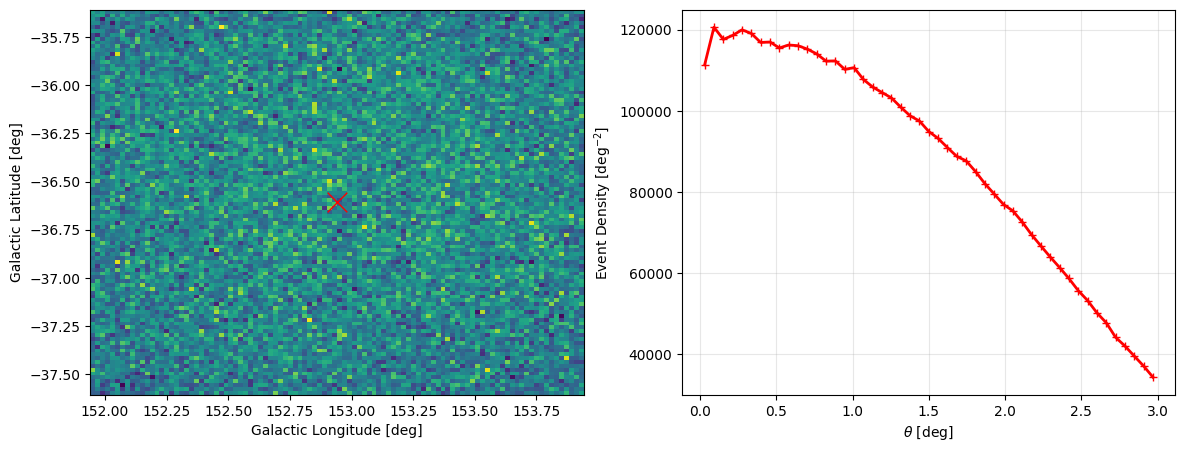

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Data overview
counts, xedges, yedges, im = ax1.hist2d(
    data["all_coords_l"],
    data["all_coords_b"],
    bins=100,
    range=[[blazar_l - 1, blazar_l + 1], [blazar_b - 1, blazar_b + 1]],
    cmap="viridis",
)
ax1.scatter(
    blazar_l, blazar_b, marker="x", color="red", s=200, linewidth=1,
)
ax1.set_xlabel("Galactic Longitude [deg]")
ax1.set_ylabel("Galactic Latitude [deg]")
ax1.set_title("Data overview")

# Radial distribution
radial_bins = np.linspace(0, 3, 50)
radial_counts, bin_edges = np.histogram(data["all_sep"], bins=radial_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Normalize by area
areas = np.pi * (bin_edges[1:] ** 2 - bin_edges[:-1] ** 2)
density = radial_counts / areas
ax2.plot(bin_centers, density, marker="+", color="red", linewidth=2)
ax2.set_xlabel(r"$\theta$ [deg]")
ax2.set_ylabel(r"Event Density [deg$^{-2}$]")
ax2.set_title("Radial Event Density Profile")
ax2.grid(True, alpha=0.3)
plt.show()

**Background removal and source power approximation**

In [17]:
# For 1ES 0229+200 there is not a lot of data. It is better to set fewer energy bins.
energy_bins = np.logspace(-1, 1, 20)
bin_edges = energy_bins
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2

src_counts, _ = np.histogram(data["src_energy"], bins=energy_bins)
bkg_counts, _ = np.histogram(data["bkg_energy"], bins=energy_bins)
net_counts = src_counts - bkg_counts

# Considering a Poisson distribution.
src_errors = np.sqrt(src_counts)
bkg_errors = np.sqrt(bkg_counts)
net_errors = np.sqrt(src_counts + bkg_counts)

In [18]:
# Source SED approximation
blazar_offset = np.mean(data["offsets"])
dE = energy_bins[1:] - energy_bins[:-1]
exposure_time = np.sum(data["t_tot"])
effective_area = (
    aeff.evaluate(energy_true=bin_centers * u.TeV, offset=blazar_offset * u.deg)
    .to(u.cm**2)
    .value
)
sed_points = net_counts * (bin_centers**2) / (exposure_time * effective_area * dE)
sed_errors = net_errors * (bin_centers**2) / (exposure_time * effective_area * dE)

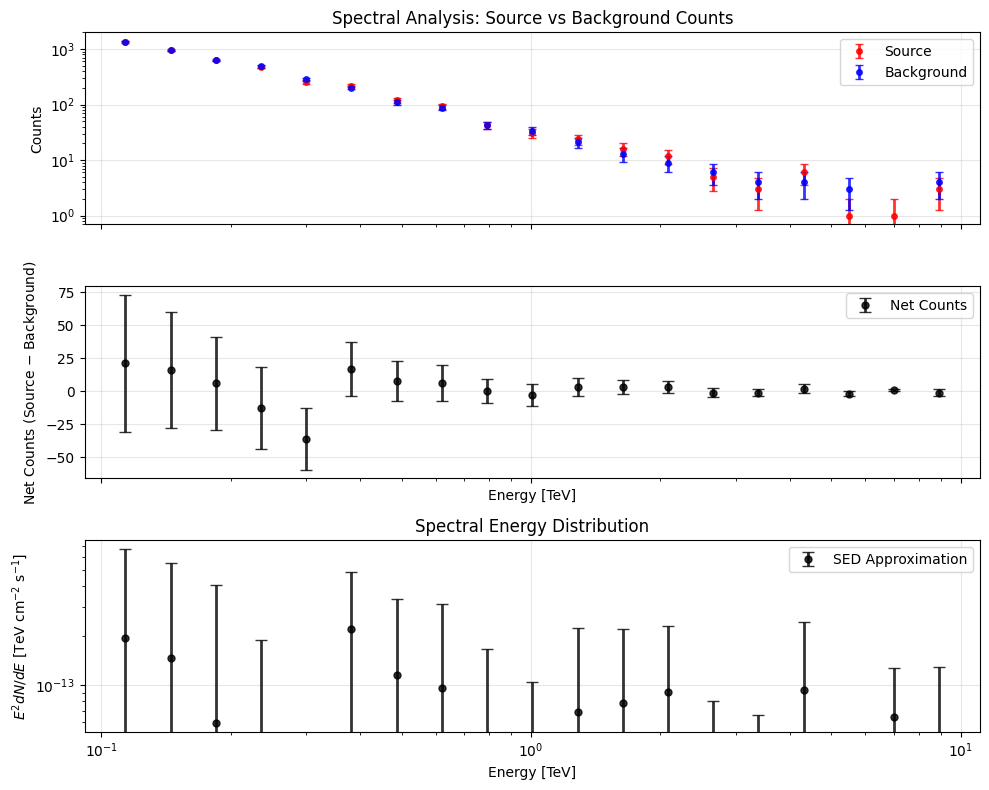

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Displaying source & background counts
ax1.errorbar(
    bin_centers,
    src_counts,
    yerr=src_errors,
    fmt="o",
    color="red",
    markersize=4,
    linewidth=2,
    label="Source",
    capsize=3,
    alpha=0.8,
)
ax1.errorbar(
    bin_centers,
    bkg_counts,
    yerr=bkg_errors,
    fmt="o",
    color="blue",
    markersize=4,
    linewidth=2,
    label="Background",
    capsize=3,
    alpha=0.8,
)
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylabel("Counts")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title("Spectral Analysis: Source vs Background Counts")

# Displaying (source - background) counts
ax2.errorbar(
    bin_centers,
    net_counts,
    yerr=net_errors,
    fmt="o",
    color="black",
    markersize=5,
    linewidth=2,
    label="Net Counts",
    capsize=4,
    alpha=0.8,
)
ax2.set_xscale("log")
ax2.set_xlabel("Energy [TeV]")
ax2.set_ylabel("Net Counts (Source $-$ Background)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Displaying SED
ax3.errorbar(
    bin_centers,
    sed_points,
    yerr=sed_errors,
    fmt="o",
    color="black",
    markersize=5,
    linewidth=2,
    label="SED Approximation",
    capsize=4,
    alpha=0.8,
)
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("Energy [TeV]")
ax3.set_ylabel(r"$E^2 dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_title("Spectral Energy Distribution")

plt.tight_layout()
plt.show()

**Statistical tests for source detection**

In [30]:
# Statistical tests for source detection
t_stat, p_value = scipy.stats.ttest_1samp(net_counts, 0)

total_background = np.sum(bkg_counts)
total_observed = np.sum(src_counts)
p_value_poisson = 1 - poisson.cdf(total_observed - 1, total_background)

print(f"T-test: t = {t_stat:.3f}, p = {p_value:.3f}")
print(f"Poisson test: p = {p_value_poisson:.3e}")

T-test: t = 0.555, p = 0.586
Poisson test: p = 3.299e-01
